In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load GDP per Capita Data (Excel format, skip first 3 lines of metadata)
gdp_df = pd.read_excel('GDP_per_capita.xls', skiprows=3)

# Load Mortality Data (Excel format, skip first 3 lines)
mortality_df = pd.read_excel('Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%).xls', skiprows=3)

# Load Life Expectancy Data (CSV format)
life_exp_df = pd.read_csv('life_expectency.csv')

print("Data loaded successfully!")
print("GDP Shape:", gdp_df.shape)
print("Mortality Shape:", mortality_df.shape)
print("Life Expectancy Shape:", life_exp_df.shape)

Data loaded successfully!
GDP Shape: (266, 70)
Mortality Shape: (266, 70)
Life Expectancy Shape: (24420, 34)


In [3]:
# Reshape GDP Data
gdp_long = gdp_df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], 
    var_name='Year', 
    value_name='GDP_per_capita'
)
# drop empty columns
gdp_long = gdp_long[gdp_long['Year'].astype(str).str.isnumeric() == True]
gdp_long['Year'] = gdp_long['Year'].astype(int)
gdp_long = gdp_long[['Country Code', 'Country Name', 'Year', 'GDP_per_capita']]

# Reshape Mortality Data
mortality_long = mortality_df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], 
    var_name='Year', 
    value_name='NCD_Mortality_Rate'
)
mortality_long = mortality_long[mortality_long['Year'].astype(str).str.isnumeric() == True]
mortality_long['Year'] = mortality_long['Year'].astype(int)
mortality_long = mortality_long[['Country Code', 'Year', 'NCD_Mortality_Rate']]

display(gdp_long.head(3))
display(mortality_long.head(3))

,Country Code,Country Name,Year,GDP_per_capita
0,ABW,Aruba,1960,NaN
1,AFE,Africa Eastern and Southern,1960,186.089204
2,AFG,Afghanistan,1960,NaN


,Country Code,Year,NCD_Mortality_Rate
0,ABW,1960,NaN
1,AFE,1960,NaN
2,AFG,1960,NaN


In [4]:
# The WHO dataset contains "Life expectancy at birth" AND "Life expectancy at age 60". We only want life expectancy at birth
life_birth = life_exp_df[life_exp_df['Indicator'] == 'Life expectancy at birth (years)']

# Filter relevant columns from the cleaned WHO dataset
life_clean = life_birth[['SpatialDimValueCode', 'Location', 'Period', 'Dim1', 'FactValueNumeric']]

# Rename columns to match the World Bank data for merging
life_clean.columns = ['Country Code', 'Country Name (WHO)', 'Year', 'Sex', 'Life_Expectancy']

# Convert Year to integer
life_clean['Year'] = life_clean['Year'].astype(int)

display(life_clean.head(3))

,Country Code,Country Name (WHO),Year,Sex,Life_Expectancy
0,LSO,Lesotho,2021,Male,48.73
1,CAF,Central African Republic,2021,Male,49.57
2,LSO,Lesotho,2021,Both sexes,51.48


In [5]:
# Merge 1: GDP + Mortality
merged_df = pd.merge(gdp_long, mortality_long, on=['Country Code', 'Year'], how='inner')

# Merge 2: Add Life Expectancy
final_df = pd.merge(merged_df, life_clean, on=['Country Code', 'Year'], how='inner')

# Drop the duplicate country name column
final_df = final_df.drop(columns=['Country Name (WHO)'])

# Drop rows where critical data is missing
final_df.dropna(subset=['GDP_per_capita', 'Life_Expectancy'], inplace=True)

print("Merged Dataset Info:")
final_df.info()
display(final_df.head())

Merged Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 12060 entries, 0 to 12209
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        12060 non-null  object 
 1   Country Name        12060 non-null  object 
 2   Year                12060 non-null  int32  
 3   GDP_per_capita      12060 non-null  float64
 4   NCD_Mortality_Rate  12060 non-null  float64
 5   Sex                 12060 non-null  object 
 6   Life_Expectancy     12060 non-null  float64
dtypes: float64(3), int32(1), object(3)
memory usage: 706.6+ KB


,Country Code,Country Name,Year,GDP_per_capita,NCD_Mortality_Rate,Sex,Life_Expectancy
0,AFG,Afghanistan,2000,174.930991,43.2,Male,53.25
1,AFG,Afghanistan,2000,174.930991,43.2,Both sexes,53.82
2,AFG,Afghanistan,2000,174.930991,43.2,Female,54.43
3,AGO,Angola,2000,563.733796,30.5,Male,46.97
4,AGO,Angola,2000,563.733796,30.5,Both sexes,49.37


In [6]:
# Show descriptive statistics
stats = final_df.describe()
display(stats)

# Check which years actually have overlapping data
print("\nYears with overlapping data across all datasets:")
print(sorted(final_df['Year'].unique()))

,Year,GDP_per_capita,NCD_Mortality_Rate,Life_Expectancy
count,12060.000000,12060.000000,12060.000000,12060.000000
mean,2010.477363,11777.028668,21.110000,70.245973
std,6.334033,17805.944052,7.490978,8.902335
min,2000.000000,109.593814,6.900000,36.600000
25%,2005.000000,1243.963514,15.300000,64.290000
50%,2010.000000,4072.073271,20.900000,71.980000
75%,2016.000000,13647.191508,25.500000,77.140000
max,2021.000000,134965.815442,45.300000,87.370000



Years with overlapping data across all datasets:
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


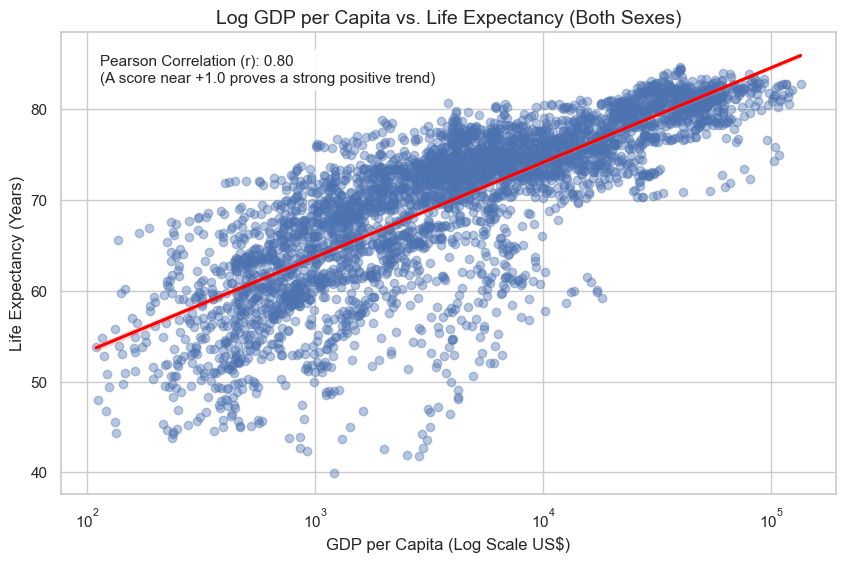

In [7]:
from scipy.stats import pearsonr

plt.figure(figsize=(10, 6))

both_sexes = final_df[final_df['Sex'] == 'Both sexes'].copy()

# Regplot
sns.regplot(
    data=both_sexes, 
    x='GDP_per_capita', 
    y='Life_Expectancy', 
    scatter_kws={'alpha':0.4, 'edgecolor':None}, 
    line_kws={'color':'red'}, # Makes the trend line stand out
    logx=True 
)
plt.xscale('log')

# Calculate exact Pearson correlation coefficient
r, p = pearsonr(np.log10(both_sexes['GDP_per_capita']), both_sexes['Life_Expectancy'])

plt.text(0.05, 0.95, f'Pearson Correlation (r): {r:.2f}\n(A score near +1.0 proves a strong positive trend)', 
         transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.title('Log GDP per Capita vs. Life Expectancy (Both Sexes)', fontsize=14)
plt.xlabel('GDP per Capita (Log Scale US$)', fontsize=12)
plt.ylabel('Life Expectancy (Years)', fontsize=12)
plt.show()

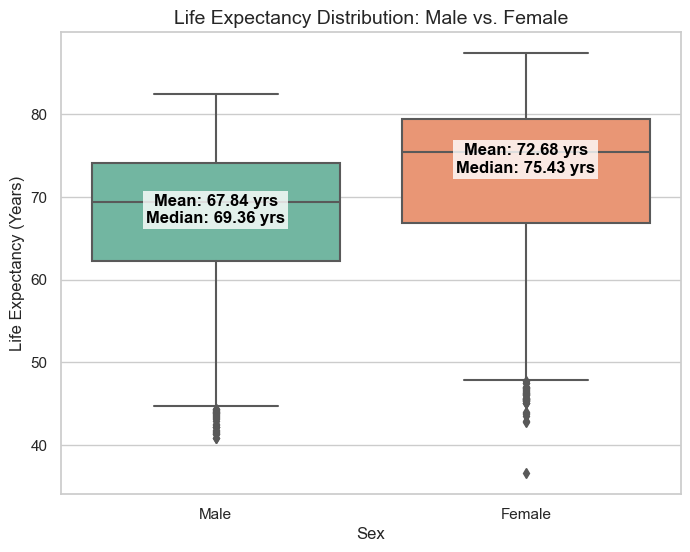

In [8]:
plt.figure(figsize=(8, 6))
gender_df = final_df[final_df['Sex'].isin(['Male', 'Female'])].copy()

# Draw the boxplot
ax = sns.boxplot(data=gender_df, x='Sex', y='Life_Expectancy', palette='Set2')

# Calculate the exact mean and median values
means = gender_df.groupby('Sex')['Life_Expectancy'].mean()
medians = gender_df.groupby('Sex')['Life_Expectancy'].median()

for i, sex in enumerate(['Male', 'Female']):
    ax.text(i, medians[sex] - 2.5, 
            f'Mean: {means[sex]:.2f} yrs\nMedian: {medians[sex]:.2f} yrs', 
            horizontalalignment='center', size='medium', color='black', weight='semibold',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2.0))

plt.title('Life Expectancy Distribution: Male vs. Female', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Life Expectancy (Years)', fontsize=12)
plt.show()

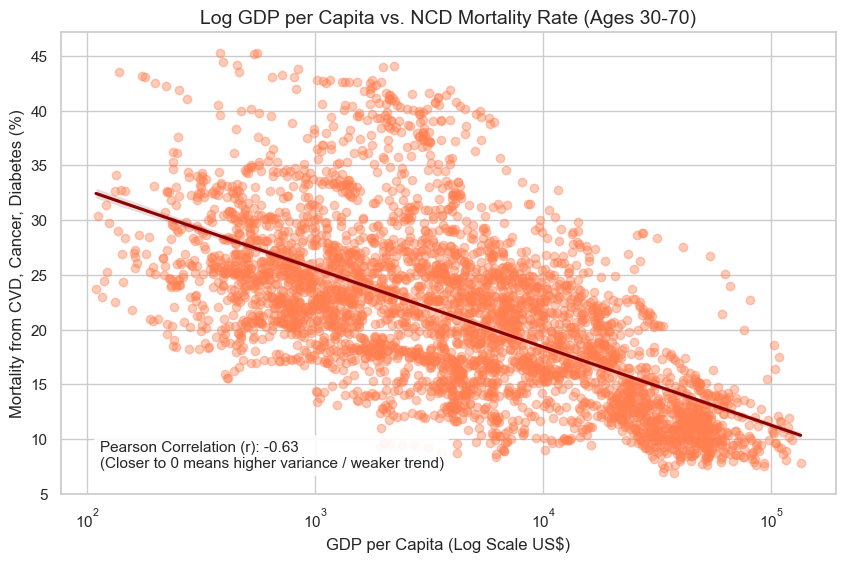

In [9]:
plt.figure(figsize=(10, 6))

sns.regplot(
    data=both_sexes, 
    x='GDP_per_capita', 
    y='NCD_Mortality_Rate', 
    scatter_kws={'alpha':0.4, 'color':'coral', 'edgecolor':None},
    line_kws={'color':'darkred'},
    logx=True
)
plt.xscale('log')

# Use pearsonr directly here too!
r_ncd, p_ncd = pearsonr(np.log10(both_sexes['GDP_per_capita']), both_sexes['NCD_Mortality_Rate'])

plt.text(0.05, 0.05, f'Pearson Correlation (r): {r_ncd:.2f}\n(Closer to 0 means higher variance / weaker trend)', 
         transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.title('Log GDP per Capita vs. NCD Mortality Rate (Ages 30-70)', fontsize=14)
plt.xlabel('GDP per Capita (Log Scale US$)', fontsize=12)
plt.ylabel('Mortality from CVD, Cancer, Diabetes (%)', fontsize=12)
plt.show()

In [10]:
avg_male = gender_df[gender_df['Sex']=='Male']['Life_Expectancy'].mean()
avg_female = gender_df[gender_df['Sex']=='Female']['Life_Expectancy'].mean()

print("--- KEY INSIGHTS FOR MILESTONE 1 REPORT ---")
print(f"1. On average across the dataset, women live {avg_female - avg_male:.2f} years longer than men.")
print(f"2. The overlapping temporal data where all 3 datasets intersect primarily falls between {final_df['Year'].min()} and {final_df['Year'].max()}.")
print(f"3. GDP and Life Expectancy maintain a strong logarithmic correlation, but NCD Mortality shows significant variance even among higher-income nations.")

--- KEY INSIGHTS FOR MILESTONE 1 REPORT ---
1. On average across the dataset, women live 4.84 years longer than men.
2. The overlapping temporal data where all 3 datasets intersect primarily falls between 2000 and 2021.
3. GDP and Life Expectancy maintain a strong logarithmic correlation, but NCD Mortality shows significant variance even among higher-income nations.
